In [ ]:
import json
import random
import os
import numpy as np
import pandas as pd
from utils import deduplicate_data, calculate_cost_from_token_usage, calculate_time_from_data, get_score_from_file

methods = [
    "Zero-shot", "CoT", "CoT-SC", "MultiPersona", "Self-Refine",
    "MedPrompt", "MedAgents", "MDAgents", "SPO", "AFlow", "MedAgents-2"
]
tasks = [
    "MedQA", "PubMedQA", "MedMCQA", "MedBullets", "MMLU",
    "MMLU-Pro", "MedExQA", "MedXpertQA-R", "MedXpertQA-U"
]
# Each entry: [mean_gpt4o-mini, std_gpt4o-mini, mean_gpt4o, std_gpt4o, mean_o3-mini, std_o3-mini]
results = {
    "Zero-shot": [
        [21.3, 2.1, 33.3, 1.5, 53.0, 0.0], [11.0, 1.0, 8.3, 1.2, 16.0, 0.0], [17.3, 0.6, 23.7, 1.2, 24.0, 0.0], [9.4, 0.6, 21.0, 1.7, 50.6, 0.0],
        [14.6, 2.1, 25.6, 1.6, 35.6, 0.0], [10.7, 1.5, 19.7, 1.5, 15.0, 0.0], [5.7, 1.5, 15.7, 2.1, 18.0, 0.0], [5.7, 0.6, 9.3, 2.1, 25.0, 0.0], [5.3, 0.6, 8.3, 2.1, 15.0, 0.0]
    ],
    "CoT": [
        [24.7, 3.2, 44.0, 4.4, 56.7, 2.1], [14.3, 1.5, 11.3, 3.2, 15.0, 1.7], [23.3, 2.5, 31.3, 1.5, 27.7, 3.2], [17.6, 0.6, 30.7, 2.3, 49.1, 1.3],
        [26.0, 2.4, 31.1, 4.4, 38.4, 2.7], [35.7, 2.1, 37.7, 2.3, 40.3, 2.1], [15.7, 1.5, 21.0, 2.6, 19.7, 1.5], [7.3, 2.3, 14.3, 2.1, 28.0, 3.6], [12.3, 2.5, 14.0, 1.0, 22.7, 3.2]
    ],
    "CoT-SC": [
        [21.7, 2.1, 42.3, 5.0, 0.0, 0.0], [13.3, 2.1, 7.3, 1.5, 0.0, 0.0], [22.3, 2.1, 32.7, 2.5, 0.0, 0.0], [15.7, 1.1, 31.1, 0.6, 0.0, 0.0],
        [27.9, 0.8, 31.5, 1.4, 0.0, 0.0], [35.7, 1.5, 39.7, 4.2, 0.0, 0.0], [16.3, 3.1, 20.7, 2.3, 0.0, 0.0], [7.7, 2.1, 14.0, 4.6, 0.0, 0.0], [14.0, 1.0, 13.7, 1.5, 0.0, 0.0]
    ],
    "MultiPersona": [
        [30.3, 1.5, 45.0, 1.0, 61.0, 1.0], [16.3, 4.2, 17.3, 2.1, 16.7, 2.9], [21.7, 0.6, 29.7, 4.2, 25.7, 2.1], [16.1, 1.7, 34.5, 4.5, 54.7, 0.6],
        [26.9, 1.6, 34.7, 2.9, 39.3, 2.9], [35.0, 1.0, 39.3, 2.5, 40.3, 2.1], [15.7, 2.3, 21.0, 2.0, 20.3, 3.1], [6.7, 1.5, 16.7, 5.8, 29.7, 2.9], [11.0, 1.0, 13.0, 2.6, 22.7, 1.5]
    ],
    "Self-Refine": [
        [31.0, 3.6, 45.3, 3.8, 52.7, 2.1], [13.3, 3.2, 15.0, 2.0, 17.3, 1.5], [24.3, 0.6, 29.3, 4.0, 27.7, 2.5], [17.6, 1.7, 33.3, 5.1, 50.9, 1.7],
        [29.7, 2.1, 36.1, 2.1, 36.5, 0.8], [32.0, 2.6, 33.3, 3.1, 31.7, 1.5], [16.0, 3.0, 20.3, 1.5, 22.0, 2.0], [9.0, 2.0, 16.0, 1.0, 32.8, 1.4], [14.0, 1.7, 16.7, 2.1, 22.3, 1.2]
    ],
    "MedPrompt": [
        [21.0, 3.5, 37.3, 1.5, 59.7, 1.5], [13.7, 3.2, 11.0, 3.0, 15.3, 1.2], [18.3, 1.5, 28.0, 1.0, 27.3, 1.5], [18.4, 1.3, 24.7, 3.0, 57.3, 4.5],
        [22.8, 2.1, 32.4, 0.8, 33.8, 2.1], [36.0, 3.0, 36.3, 3.5, 37.3, 0.6], [14.3, 1.2, 21.0, 1.0, 18.3, 1.5], [7.3, 1.5, 14.3, 1.5, 29.7, 0.6], [10.7, 1.5, 13.3, 0.6, 23.3, 3.1]
    ],
    "MedAgents": [
        [25.3, 2.3, 43.0, 1.0, 58.0, 4.0], [12.3, 1.5, 17.7, 2.5, 16.3, 0.6], [22.0, 1.0, 30.3, 0.6, 26.3, 2.5], [18.7, 2.8, 29.6, 2.3, 53.5, 0.7],
        [24.2, 3.4, 29.2, 4.8, 34.7, 1.6], [31.3, 2.5, 37.7, 2.5, 38.0, 4.0], [12.0, 0.0, 20.3, 1.5, 20.3, 1.5], [7.7, 2.1, 13.0, 1.7, 28.7, 2.5], [10.7, 1.5, 12.3, 2.1, 23.0, 2.6]
    ],
    "MDAgents": [
        [24.0, 1.0, 37.6, 1.7, 58.4, 2.6], [17.1, 5.5, 21.0, 2.6, 18.9, 4.3], [22.2, 1.2, 27.4, 1.3, 29.9, 2.2], [14.2, 1.7, 20.3, 5.9, 54.4, 1.4],
        [20.4, 2.6, 28.8, 3.6, 40.8, 6.4], [31.8, 1.7, 39.7, 1.6, 41.8, 5.5], [12.3, 1.5, 21.1, 0.9, 18.4, 1.5], [5.4, 1.2, 10.4, 2.4, 29.3, 1.5], [7.0, 2.0, 10.4, 2.3, 23.3, 2.3]
    ],
    "SPO": [
        [17.7, 1.5, 32.0, 1.7, None, None], [25.7, 2.1, 31.3, 1.5, None, None], [20.7, 0.6, 30.0, 2.0, None, None], [22.5, 0.0, 28.8, 0.6, None, None],
        [22.4, 2.9, 34.7, 2.1, None, None], [32.0, 1.0, 36.7, 0.6, None, None], [15.0, 1.0, 21.0, 2.0, None, None], [11.7, 1.2, 17.0, 2.0, None, None], [13.3, 2.1, 17.3, 1.5, None, None]
    ],
    "AFlow": [
        [32.3, 2.1, 47.0, 1.0, None, None], [18.7, 3.5, 23.3, 4.6, None, None], [28.0, 3.0, 31.3, 1.5, None, None], [16.9, 1.1, 36.0, 1.9, None, None],
        [25.6, 1.6, 37.9, 3.4, None, None], [28.7, 1.5, 36.0, 3.6, None, None], [10.0, 3.0, 23.0, 2.6, None, None], [10.7, 3.5, 14.3, 2.3, None, None], [10.3, 3.5, 19.7, 1.5, None, None]
    ],
    "MedAgents-2": []
}

base_dir = "./output"
datasets = [task.lower() for task in tasks]
model_names = ["o3-mini", "gpt-4o", "gpt-4o-mini"]
split = "test_hard"
run_ids = [0, 1, 2]  # 3 runs

retrieve_topk = 20
rerank_topk = 8
rewrite = "True"
review = "False"
adaptive_rag = "auto"
similarity_strategy = "reuse"
agent_memory = "True"
allowed_sources = ["cpg", "statpearls", "recop", "textbooks"]

# Fixed pattern from main.py:
# f"{args.model_name}-{args.dataset_name}-{args.split}-retrieve-{args.retrieve_topk}-rerank-{args.rerank_topk}-rewrite-{args.rewrite}-review-{args.review}-adaptive_rag-{args.adaptive_rag}-similarity_strategy-{args.similarity_strategy}-agent_memory-{args.agent_memory}-allowed_sources-{'_'.join(args.allowed_sources)}.json"

# Add MedAgents-2 performance for each model (4o-mini, 4o, o3-mini) and save as model_avg, model_std
model_names = ["gpt-4o-mini", "gpt-4o", "o3-mini"]

for dataset in datasets:
    results["MedAgents-2"].append([])
    for model_name in model_names:
        accs, ns = [], []
        for run_id in run_ids:
            fname = f"{model_name}-{dataset}-{split}-retrieve-{retrieve_topk}-rerank-{rerank_topk}-rewrite-{rewrite}-review-{review}-adaptive_rag-{adaptive_rag}-similarity_strategy-{similarity_strategy}-agent_memory-{agent_memory}-allowed_sources-{'_'.join(allowed_sources)}.json"
            file_path = os.path.join(base_dir, dataset, f'run_{run_id}', fname)
            if os.path.exists(file_path):
                acc, n, _, _, _ = get_score_from_file(file_path, model_name)
                accs.append(acc)
                ns.append(n)
        results["MedAgents-2"][-1].extend([
            round(float(np.mean(accs)), 1),
            round(float(np.std(accs, ddof=1)), 1) if len(accs) > 1 else 0.0,
        ])

/tmp/ipykernel_36049/1251780776.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(
/tmp/ipykernel_36049/1251780776.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(
/tmp/ipykernel_36049/1251780776.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


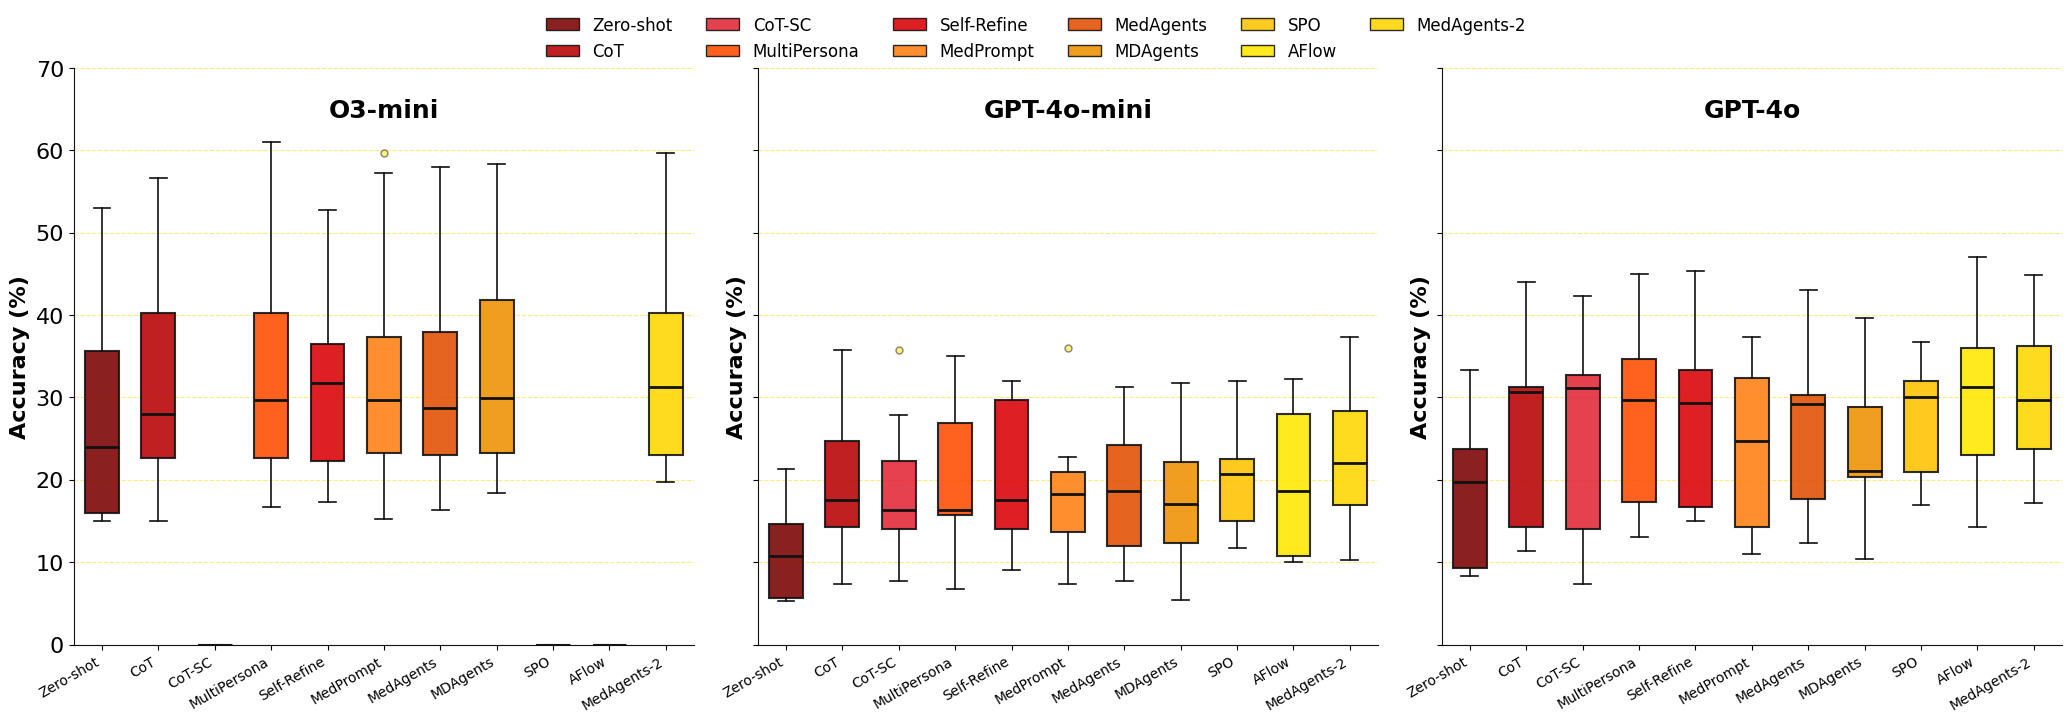

Performance Comparison Across Models and Tasks (Accuracy %)


Method,MedQA (O3-mini),PubMedQA (O3-mini),MedMCQA (O3-mini),MedBullets (O3-mini),MMLU (O3-mini),MMLU-Pro (O3-mini),MedExQA (O3-mini),MedXpertQA-R (O3-mini),MedXpertQA-U (O3-mini),MedQA (GPT-4o-mini),PubMedQA (GPT-4o-mini),MedMCQA (GPT-4o-mini),MedBullets (GPT-4o-mini),MMLU (GPT-4o-mini),MMLU-Pro (GPT-4o-mini),MedExQA (GPT-4o-mini),MedXpertQA-R (GPT-4o-mini),MedXpertQA-U (GPT-4o-mini),MedQA (GPT-4o),PubMedQA (GPT-4o),MedMCQA (GPT-4o),MedBullets (GPT-4o),MMLU (GPT-4o),MMLU-Pro (GPT-4o),MedExQA (GPT-4o),MedXpertQA-R (GPT-4o),MedXpertQA-U (GPT-4o),Average (O3-mini),Average (GPT-4o-mini),Average (GPT-4o)
MedAgents-2,59.7,19.7,26.0,52.8,40.2,40.0,20.7,31.3,23.0,32.0,21.7,25.3,22.1,28.3,37.3,17.0,10.3,15.0,44.9,17.2,29.7,36.3,35.2,43.7,27.3,20.8,23.7,34.8,23.2,31.0
AFlow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.3,18.7,28.0,16.9,25.6,28.7,10.0,10.7,10.3,47.0,23.3,31.3,36.0,37.9,36.0,23.0,14.3,19.7,0.0,20.1,29.8
MultiPersona,61.0,16.7,25.7,54.7,39.3,40.3,20.3,29.7,22.7,30.3,16.3,21.7,16.1,26.9,35.0,15.7,6.7,11.0,45.0,17.3,29.7,34.5,34.7,39.3,21.0,16.7,13.0,34.5,20.0,27.9
SPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.7,25.7,20.7,22.5,22.4,32.0,15.0,11.7,13.3,32.0,31.3,30.0,28.8,34.7,36.7,21.0,17.0,17.3,0.0,20.1,27.6
Self-Refine,52.7,17.3,27.7,50.9,36.5,31.7,22.0,32.8,22.3,31.0,13.3,24.3,17.6,29.7,32.0,16.0,9.0,14.0,45.3,15.0,29.3,33.3,36.1,33.3,20.3,16.0,16.7,32.7,20.8,27.3
CoT,56.7,15.0,27.7,49.1,38.4,40.3,19.7,28.0,22.7,24.7,14.3,23.3,17.6,26.0,35.7,15.7,7.3,12.3,44.0,11.3,31.3,30.7,31.1,37.7,21.0,14.3,14.0,33.1,19.7,26.2
CoT-SC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.7,13.3,22.3,15.7,27.9,35.7,16.3,7.7,14.0,42.3,7.3,32.7,31.1,31.5,39.7,20.7,14.0,13.7,0.0,19.4,25.9
MedAgents,58.0,16.3,26.3,53.5,34.7,38.0,20.3,28.7,23.0,25.3,12.3,22.0,18.7,24.2,31.3,12.0,7.7,10.7,43.0,17.7,30.3,29.6,29.2,37.7,20.3,13.0,12.3,33.2,18.2,25.9
MedPrompt,59.7,15.3,27.3,57.3,33.8,37.3,18.3,29.7,23.3,21.0,13.7,18.3,18.4,22.8,36.0,14.3,7.3,10.7,37.3,11.0,28.0,24.7,32.4,36.3,21.0,14.3,13.3,33.6,18.1,24.3
MDAgents,58.4,18.9,29.9,54.4,40.8,41.8,18.4,29.3,23.3,24.0,17.1,22.2,14.2,20.4,31.8,12.3,5.4,7.0,37.6,21.0,27.4,20.3,28.8,39.7,21.1,10.4,10.4,35.0,17.2,24.1


\begin{table*}[t]
  \centering
  \small
  \setlength{\tabcolsep}{2.2mm}{
  \scalebox{0.47}{
  \begin{tabular}{l|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
    \toprule
    \textbf{Method} & \multicolumn{3}{c|}{\textbf{MedQA}} & \multicolumn{3}{c|}{\textbf{PubMedQA}} & \multicolumn{3}{c|}{\textbf{MedMCQA}} & \multicolumn{3}{c|}{\textbf{MedBullets}} & \multicolumn{3}{c|}{\textbf{MMLU}} & \multicolumn{3}{c|}{\textbf{MMLU-Pro}} & \multicolumn{3}{c|}{\textbf{MedExQA}} & \multicolumn{3}{c|}{\textbf{MedXpertQA-R}} & \multicolumn{3}{c|}{\textbf{MedXpertQA-U}} & \multicolumn{3}{c|}{\textbf{Average}} \\
    \midrule
     &  \footnotesize{\textsc{4o-m}} & \textsc{4o} & \textsc{o3-m} &  \footnotesize{\textsc{4o-m}} & \textsc{4o} & \textsc{o3-m} &  \footnotesize{\textsc{4o-m}} & \textsc{4o} & \textsc{o3-m} &  \footnotesize{\textsc{4o-m}} & \textsc{4o} & \textsc{o3-m} &  \footnotesize{\textsc{4o-m}} & \textsc{4o} & \textsc{o3-m} &  \footnotesize{\textsc{4o-m}} & \textsc{4o} & \tex

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

# --- Manchester United SIUUU Color Palette ---
# Only reds, oranges, yellows, black, white, gold. No green!
MU_COLORS = {
    "Maroon": "#7B0101",         # Deep red
    "UE Red": "#B80102",         # United red
    "Rosso Corsa": "#DA0106",    # Vivid red
    "Scarlet": "#E32636",        # Scarlet (between vivid red and orange)
    "Vermilion": "#FF4B00",      # Vermilion (red-orange, between red and orange)
    "Persimmon": "#E14F01",      # Deep orange
    "Orange": "#FF7F11",         # True orange (between deep orange and tangerine)
    "Tangerine": "#EF9101",      # Orange accent
    "Amber": "#FFC300",          # Amber (between orange and yellow)
    "Vivid Yellow": "#FFE600",   # Vivid yellow
    "Gold": "#FFD700",           # Gold (trophy)
    "Black": "#111111",          # Black (outlines, text)
    "White": "#FFFFFF",          # White (contrast)
    "Dark Gray": "#222222",      # Dark gray (backgrounds)
    # No green, SIUUU!
}

# For methods, assign a color from the palette, cycling if needed
MU_METHOD_COLORS = [
    MU_COLORS["Maroon"],
    MU_COLORS["UE Red"],
    MU_COLORS["Scarlet"],
    MU_COLORS["Vermilion"],
    MU_COLORS["Rosso Corsa"],
    MU_COLORS["Orange"],
    MU_COLORS["Persimmon"],
    MU_COLORS["Tangerine"],
    MU_COLORS["Amber"],
    MU_COLORS["Vivid Yellow"],
    MU_COLORS["Gold"],
]

# Prepare data for all three models: o3-mini, gpt-4o-mini, gpt-4o
def safe_extract(results, method, idx, col):
    try:
        val = results[method][idx][col]
        if val is None:
            return np.nan
        return val
    except Exception:
        return np.nan

data_o3mini = {method: [safe_extract(results, method, i, 4) for i in range(len(tasks))] for method in methods}
data_gpt4o_mini = {method: [safe_extract(results, method, i, 0) for i in range(len(tasks))] for method in methods}
data_gpt4o = {method: [safe_extract(results, method, i, 2) for i in range(len(tasks))] for method in methods}

# --- Boxplot visualization ---
plt.rcParams.update({'font.size': 16, 'font.family': 'DejaVu Sans'})

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7), sharey=True)

model_data_dicts = [
    (data_o3mini, 'O3-mini'),
    (data_gpt4o_mini, 'GPT-4o-mini'),
    (data_gpt4o, 'GPT-4o')
]

num_methods = len(methods)
# Use only reds, oranges, yellows, gold, black, white, dark gray for method colors
colors = [MU_METHOD_COLORS[i % len(MU_METHOD_COLORS)] for i in range(num_methods)]

for ax, (data_dict, model_title) in zip(axes, model_data_dicts):
    # Prepare data for boxplot: each method is a list of values (across tasks)
    box_data = []
    for method in methods:
        vals = data_dict[method]
        # Replace None or np.nan with 0.0 for plotting
        vals = [0.0 if (v is None or (isinstance(v, float) and np.isnan(v))) else v for v in vals]
        box_data.append(vals)
    # Boxplot
    bplot = ax.boxplot(
        box_data,
        patch_artist=True,
        labels=methods,
        medianprops=dict(color=MU_COLORS["Black"], linewidth=2),
        boxprops=dict(linewidth=1.5, color=MU_COLORS["Black"]),
        whiskerprops=dict(linewidth=1.2, color=MU_COLORS["Black"]),
        capprops=dict(linewidth=1.2, color=MU_COLORS["Black"]),
        flierprops=dict(marker='o', markersize=5, markerfacecolor=MU_COLORS["Vivid Yellow"], alpha=0.5, markeredgecolor=MU_COLORS["Black"]),
        widths=0.6
    )
    # Color each box
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.88)
        patch.set_edgecolor(MU_COLORS["Black"])
    ax.set_title(model_title, fontsize=18, fontweight='bold', y=0.9)
    ax.set_xticklabels(methods, rotation=30, ha='right', fontsize=10)
    ax.set_ylabel('Accuracy (%)', fontsize=16, fontweight='bold')
    ax.set_ylim(0, 70)
    ax.grid(axis='y', linestyle='--', alpha=0.5, color=MU_COLORS["Gold"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(MU_COLORS["Black"])
    ax.spines['bottom'].set_color(MU_COLORS["Black"])

# Create a legend for methods (colors)
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=colors[i], edgecolor=MU_COLORS["Black"], label=methods[i], alpha=0.88) for i in range(num_methods)]
fig.legend(
    handles=legend_handles,
    labels=methods,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=6,
    frameon=False,
    fontsize=12,
)

plt.subplots_adjust(left=0.05, right=0.95)  # Reduce margins on left and right
plt.savefig('o3mini_gpt4o_mini_gpt4o_performance_boxplot.pdf', dpi=300, bbox_inches='tight', facecolor=MU_COLORS["White"])
plt.tight_layout()
plt.show()

# --- Table and LaTeX output (unchanged except for color tweaks) ---
def calculate_average_performance(data):
    method_averages = {}
    for method_name, method_data in data.items():
        # Only use non-nan values for averaging
        vals = [v for v in method_data if v is not None and not (isinstance(v, float) and np.isnan(v))]
        if len(vals) == 0:
            method_averages[method_name] = 0.0
        else:
            method_averages[method_name] = round(sum(vals) / len(vals), 1)
    return method_averages

o3mini_averages = calculate_average_performance(data_o3mini)
gpt4o_mini_averages = calculate_average_performance(data_gpt4o_mini)
gpt4o_averages = calculate_average_performance(data_gpt4o)

comparison_data = []
for method in methods:
    row = {'Method': method}
    # Add individual task performances for o3-mini
    for i in range(len(tasks)):
        v = data_o3mini[method][i]
        row[f'{tasks[i]} (O3-mini)'] = 0.0 if (v is None or (isinstance(v, float) and np.isnan(v))) else v
    # Add individual task performances for GPT-4o-mini
    for i in range(len(tasks)):
        v = data_gpt4o_mini[method][i]
        row[f'{tasks[i]} (GPT-4o-mini)'] = 0.0 if (v is None or (isinstance(v, float) and np.isnan(v))) else v
    # Add individual task performances for GPT-4o
    for i in range(len(tasks)):
        v = data_gpt4o[method][i]
        row[f'{tasks[i]} (GPT-4o)'] = 0.0 if (v is None or (isinstance(v, float) and np.isnan(v))) else v
    # Add average performances
    row['Average (O3-mini)'] = o3mini_averages[method]
    row['Average (GPT-4o-mini)'] = gpt4o_mini_averages[method]
    row['Average (GPT-4o)'] = gpt4o_averages[method]
    comparison_data.append(row)

# Create DataFrame and sort by average performance (descending, by GPT-4o)
df = pd.DataFrame(comparison_data)
df = df.sort_values(by='Average (GPT-4o)', ascending=False)

# Find best and second best for each column
best_values = {}
second_best_values = {}
for col in df.columns:
    if col != 'Method':
        # Only consider non-nan values for best/second-best
        col_vals = [v for v in df[col].unique() if v is not None and not (isinstance(v, float) and np.isnan(v))]
        sorted_values = sorted(col_vals, reverse=True)
        if len(sorted_values) >= 1:
            best_values[col] = sorted_values[0]
        if len(sorted_values) >= 2:
            second_best_values[col] = sorted_values[1]

# Format the table for display with best (bold) and second best (underline) values
formatted_df = df.copy()
for col in formatted_df.columns:
    if col != 'Method':
        formatted_df[col] = formatted_df[col].apply(
            lambda x: f"<b>{x:.1f}</b>" if x == best_values.get(col) else 
                     (f"<u>{x:.1f}</u>" if x == second_best_values.get(col) else f"{x:.1f}")
        )

# Display the table
print("Performance Comparison Across Models and Tasks (Accuracy %)")
display(HTML(formatted_df.to_html(index=False, escape=False)))

# --- LaTeX Table with Heatmap Coloring and Best/Second-Best Formatting (with std) ---

num_tasks = len(tasks)
models = ["gpt-4o-mini", "gpt-4o", "o3-mini"]
num_models = len(models)
num_cols = num_tasks * num_models

# Prepare table_data: each row is a method, each cell is ((mean, std), formatted_str)
table_data = []
for method in methods:
    row_cells = []
    for i in range(num_tasks):
        for m in range(num_models):
            # results[method][i] = [mean_gpt4o-mini, std_gpt4o-mini, mean_gpt4o, std_gpt4o, mean_o3-mini, std_o3-mini]
            entry = results[method][i]
            mean = entry[m*2]
            std = entry[m*2+1]
            if mean is not None:
                row_cells.append(((mean, std), f"{mean:.1f} $\\pm$ {std:.1f}"))
            else:
                row_cells.append(((None, None), "N/A"))
    # Average columns
    for m in range(num_models):
        vals = []
        for i in range(num_tasks):
            entry = results[method][i]
            mean = entry[m*2]
            if mean is not None:
                vals.append(mean)
        if vals:
            avg_mean = float(np.mean(vals))
            avg_std = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
            row_cells.append(((avg_mean, avg_std), f"{avg_mean:.1f} $\\pm$ {avg_std:.1f}"))
        else:
            row_cells.append(((None, None), "N/A"))
    table_data.append(row_cells)

# Step 2: Determine the best and second best values and the min/max for heatmap normalization per column.
num_total_cols = num_tasks * num_models + num_models  # all task/model columns + average/model columns
col_best = [None] * num_total_cols
col_second = [None] * num_total_cols
col_min = [None] * num_total_cols
col_max = [None] * num_total_cols

for col_idx in range(num_total_cols):
    col_values = []
    for row in table_data:
        val = row[col_idx][0][0]  # mean
        if val is not None:
            col_values.append(val)
    if col_values:
        best_val = max(col_values)
        col_best[col_idx] = best_val
        lower_values = [v for v in col_values if v < best_val]
        col_second[col_idx] = max(lower_values) if lower_values else None
        col_min[col_idx] = min(col_values)
        col_max[col_idx] = max(col_values)
    else:
        col_best[col_idx] = None
        col_second[col_idx] = None
        col_min[col_idx] = None
        col_max[col_idx] = None

# Optional: pretty names for methods and tasks
method_map = {}
task_map = {}

# Step 3: Print the LaTeX table with heatmap coloring and best/second-best formatting based on column.
print("\\begin{table*}[t]")
print("  \\centering")
print("  \\small")
print("  \\setlength{\\tabcolsep}{2.2mm}{")
print("  \\scalebox{0.47}{")
print(f"  \\begin{{tabular}}{{l|{'c|' * (num_tasks * num_models)}{'c|' * num_models}}}")
print("    \\toprule")
header1 = ["\\textbf{Method}"]
for task in tasks:
    header1.append(f"\\multicolumn{{{num_models}}}{{c|}}{{\\textbf{{{task_map.get(task, task)}}}}}")
header1.append(f"\\multicolumn{{{num_models}}}{{c|}}{{\\textbf{{Average}}}}")
print("    " + " & ".join(header1) + " \\\\")
print("    \\midrule")
header2 = [""] + [" \\footnotesize{\\textsc{4o-m}} & \\textsc{4o} & \\textsc{o3-m}"] * (len(tasks) + 1)
print("    " + " & ".join(header2) + " \\\\")
print("    \\midrule")

for row_idx, method in enumerate(methods):
    formatted_method = "\\textsc{" + method_map.get(method, method) + "}"
    row_cells = [formatted_method]
    for j, (cell_val, cell_str) in enumerate(table_data[row_idx]):
        mean_val, std_val = cell_val
        # Use per-column min/max/best/second-best
        if mean_val is not None and col_min[j] is not None and col_max[j] is not None:
            if (col_max[j] - col_min[j]) != 0:
                norm = (mean_val - col_min[j]) / (col_max[j] - col_min[j])
            else:
                norm = 1
            r = int(round(255 + norm * (238 - 255)))
            g = int(round(255 + norm * (156 - 255)))
            b = int(round(255 + norm * (167 - 255)))
            color_hex = f"{r:02X}{g:02X}{b:02X}"
            cell_text = f"{mean_val:.1f} $\\pm$ {std_val:.1f}"
            if mean_val == col_best[j]:
                cell_text = "\\textbf{" + cell_text + "}"
            elif col_second[j] is not None and mean_val == col_second[j]:
                cell_text = "\\underline{" + cell_text + "}"
            cell_str = f"\\cellcolor[HTML]{{{color_hex}}}" + cell_text
        else:
            cell_str = "N/A"
        row_cells.append(cell_str)
    print("    " + " & ".join(row_cells) + " \\\\")
    print("    \\midrule")
print("    \\bottomrule")
print("  \\end{tabular}")
print("  }")
print("}")
print("  \\caption{\\textbf{Performance heatmap by task and method.} All the tasks are evaluated on the \\textsc{Hard} set. For each task, three models are evaluated in order: \\textsc{GPT-4o-mini}, \\textsc{GPT-4o}, and \\textsc{o3-mini}. Accuracy values are in percentages, shown as mean $\\pm$ std. The best values are highlighted in \\textbf{bold}, and the second-best values are highlighted in \\underline{underlined} format.}")
print("  \\label{tab:method_task_heatmap}")
print("\\end{table*}")
